In [1]:
import ee
ee.Initialize()
import constants
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, UnidentifiedImageError
from requests.adapters import HTTPAdapter, Retry
from requests import Session
from io import BytesIO
import pandas as pd
import pickle as pkl

In [2]:
def maskS2clouds(image):
    qa = image.select('QA60')

    ##Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    #Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))

    return image.updateMask(mask).divide(10000);



In [3]:
def GEELoadImage(image,geometry,rgb_only=True):
    #Initialize 3 or 10 band list
    if rgb_only:
        bands=['B4','B3','B2']
    else:
        bands=['B1','B4','B3','B2','B5','B7','B8A','B8','B11','B12']
    
    #Query gee for the relevant image, attempt 5 times and convert it into an np array of shape (constants.GEE_IMAGE_SHAPE,constants.GEE_IMAGE_SHAPE,len(bands))
    try:
        #Initialize request and it's parameters
        thumbUrl=image.getThumbUrl({
            'region':geometry,
            'bands':bands,
            'min':0,
            'max':.3000,
            'format':constants.GEE_IMAGE_FORMAT,
            'crs':'EPSG:3857',
            'dimensions':str(constants.GEE_IMAGE_SHAPE)+'x'+str(constants.GEE_IMAGE_SHAPE),
        })
        
        #Initialize request handler and exponential backoff in case of unexpected server error (ensures some degree of redundancy and avoid overwhelming gee)
        s = Session()
        retries = Retry(
            total=0,
            backoff_factor=0.1,
            status_forcelist=[429, 500, 502, 503, 504]
        )
        s.mount(thumbUrl, HTTPAdapter(max_retries=retries))
        
        #Make and await response from gee, timeout after 15 seconds
        response = s.get(thumbUrl,timeout=15)
        
        #Change bytes response to a PIL RGB image and then to a numpy array, ensure shape integrity, else return None
        with Image.open(BytesIO(response.content)) as img:
            img = np.array(img.convert('RGB'))
            if img.shape != (constants.GEE_IMAGE_SHAPE,constants.GEE_IMAGE_SHAPE,len(bands)):
                return None
    
    #Catch all relevant exceptions and print relevant error text 
    except ee.EEException as e:
        print("Earth Engine Failure",e)
        return None
    except UnidentifiedImageError as p:
        print("Bad GEE Image Response",response.content)
        return None
    except Exception as e:
        print('Unknown Exception',e)
        return None

    return img

In [7]:
country = ee.FeatureCollection(constants.GEE_COUNTRY_DATASET).filter(ee.Filter.eq('country_na','India'))
tgeo=country.geometry().coveringGrid("EPSG:3857",22400)
length=tgeo.size().getInfo()
rand=random.randrange(8056)
print('randtile',rand)
tile=tgeo.toList(1,rand).getInfo()[0]
randsub=random.randrange(1024)
print('randsub',randsub)
sgeo=ee.Geometry(tile['geometry']).coveringGrid('EPSG:3857',700)
subtile=sgeo.toList(1,randsub).getInfo()[0]
print(subtile)

randtile 6233
randsub 689
{'type': 'Feature', 'geometry': {'geodesic': False, 'crs': {'type': 'name', 'properties': {'name': 'EPSG:3857'}}, 'type': 'Polygon', 'coordinates': [[[8859900, 3150700], [8860600, 3150700], [8860600, 3151400], [8859900, 3151400], [8859900, 3150700]]]}, 'id': '12657,4501', 'properties': {}}


In [10]:
totalDataset=pd.read_csv(constants.PREDICTION_ROOT+constants.GROUPING_DATASET_NAME+'_results.csv').to_dict()
idx=list(totalDataset['idx'].values()).index(2113253)
randtile=eval(totalDataset['geometry'][idx])
"""
dictlen=random.randrange(len(totalDataset['geometry']))
print('random tile',dictlen)
randtile=eval(totalDataset['geometry'][dictlen])
"""

"\ndictlen=random.randrange(len(totalDataset['geometry']))\nprint('random tile',dictlen)\nrandtile=eval(totalDataset['geometry'][dictlen])\n"

uint8
max 180
min 46


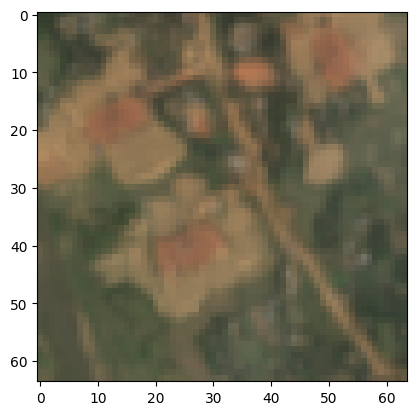

In [11]:
lowres_collection=ee.ImageCollection(constants.GEE_SATELLITE).filterDate(constants.GEE_START_DATE,constants.GEE_END_DATE)
for filters,bounds in zip(constants.GEE_FILTERS,constants.GEE_FILTERS_BOUNDS):
    lowres_collection=lowres_collection.filter(ee.Filter.lte(filters,bounds))
try:
    lowRes_collection=lowres_collection.filterBounds(ee.Geometry(randtile['geometry'])).map(maskS2clouds)
    image=lowRes_collection.mean().clip(ee.Geometry(randtile['geometry']))
    data=GEELoadImage(image,randtile['geometry'],rgb_only=True)
    print(data.dtype)
    plt.imshow(data)
    print('max',np.max(data))
    print('min',np.min(data))
except Exception as e:
    print(e)
    data=None


In [9]:
datasetName=constants.GROUPING_DATASET_NAME
lrfile=open(constants.GROUPING_ROOT+datasetName+'/'+datasetName+"LrBatch"+str(0),'r+b')
imageDict=pkl.load(lrfile)
lrfile.close()


In [10]:
print(imageDict[471155][1])
print(randtile)

{'type': 'Feature', 'geometry': {'geodesic': False, 'crs': {'type': 'name', 'properties': {'name': 'EPSG:3857'}}, 'type': 'Polygon', 'coordinates': [[[9429000, 2528400], [9429700, 2528400], [9429700, 2529100], [9429000, 2529100], [9429000, 2528400]]]}, 'id': '13470,3612', 'properties': {}}
{'type': 'Feature', 'geometry': {'geodesic': False, 'crs': {'type': 'name', 'properties': {'name': 'EPSG:3857'}}, 'type': 'Polygon', 'coordinates': [[[9429000, 2528400], [9429700, 2528400], [9429700, 2529100], [9429000, 2529100], [9429000, 2528400]]]}, 'id': '13470,3612', 'properties': {}}


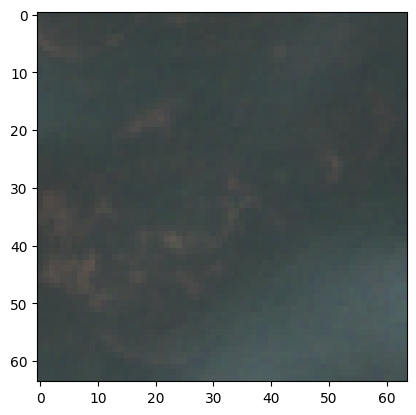

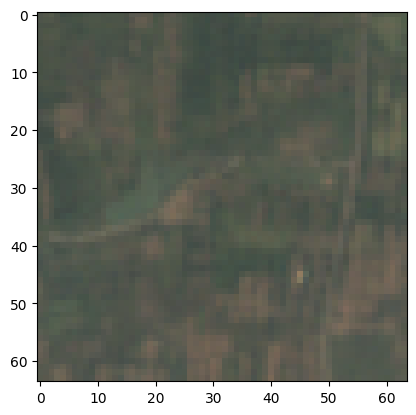

In [15]:
lowres_collection=ee.ImageCollection(constants.GEE_SATELLITE).filterDate(constants.GEE_START_DATE,constants.GEE_END_DATE)
for filters,bounds in zip(constants.GEE_FILTERS,constants.GEE_FILTERS_BOUNDS):
    lowres_collection=lowres_collection.filter(ee.Filter.lte(filters,bounds))
try:
    lowRes_collection=lowres_collection.filterBounds(ee.Geometry(randtile['geometry']))
    image=lowRes_collection.sort(constants.GEE_SORT_CATEGORY).first().clip(ee.Geometry(randtile['geometry']))
    data=GEELoadImage(image,randtile['geometry'],rgb_only=True)
    randomdata=pkl.dumps(data)
    here=pkl.loads(randomdata)
    plt.imshow(here)
    plt.figure()
    plt.imshow(imageDict[471155][0])
except:
    print('fuck')